<a href="https://colab.research.google.com/github/kanishkautag/RNN-Google-Stock-Price/blob/main/RNN02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
34/34 [==============================] - 16s 165ms/step - loss: 0.1448 - val_loss: 0.0862
Epoch 2/100
34/34 [==============================] - 4s 112ms/step - loss: 0.0392 - val_loss: 0.0667
Epoch 3/100
34/34 [==============================] - 6s 188ms/step - loss: 0.0306 - val_loss: 0.0329
Epoch 4/100
34/34 [==============================] - 5s 160ms/step - loss: 0.0325 - val_loss: 0.0803
Epoch 5/100
34/34 [==============================] - 5s 148ms/step - loss: 0.0262 - val_loss: 0.0433
Epoch 6/100
34/34 [==============================] - 6s 182ms/step - loss: 0.0275 - val_loss: 0.0455
Epoch 7/100
34/34 [==============================] - 4s 118ms/step - loss: 0.0283 - val_loss: 0.0139
Epoch 8/100
34/34 [==============================] - 5s 157ms/step - loss: 0.0253 - val_loss: 0.0406
Epoch 9/100
34/34 [==============================] - 4s 114ms/step - loss: 0.0250 - val_loss: 0.0324
Epoch 10/100
34/34 [==============================] - 4s 114ms/step - loss: 0.0235 - val_l

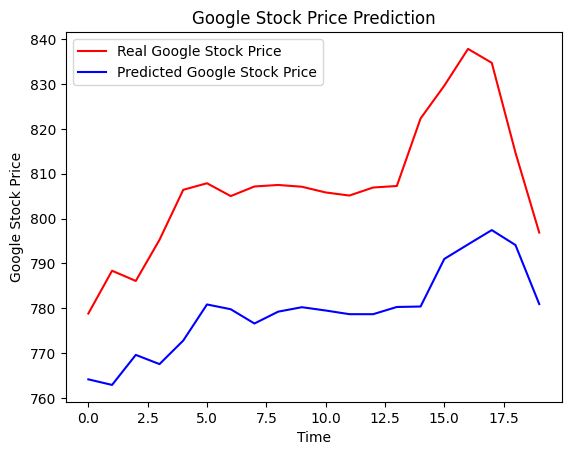

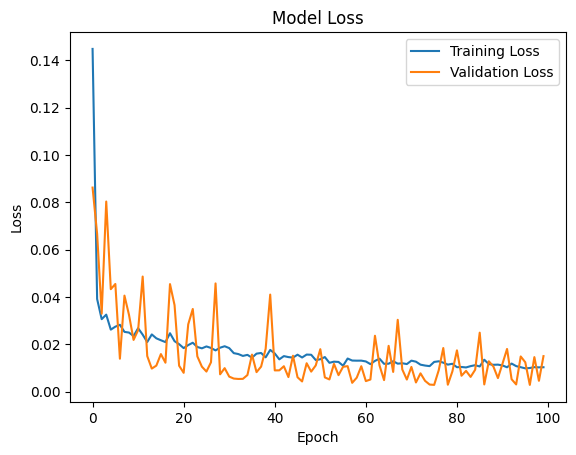

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
dataset_train = pd.read_csv("/content/Google_Stock_Price_Train.csv", thousands=',',
                            dtype={'Date': str, 'Open': float, 'High': float, 'Low': float, 'Close': float, 'Volume': int})
dataset_test = pd.read_csv("/content/Google_Stock_Price_Test.csv", thousands=',',
                           dtype={'Date': str, 'Open': float, 'High': float, 'Low': float, 'Close': float, 'Volume': int})

# Prepare the training data
training_set = dataset_train.iloc[:, 1:2].values  # Using only 'Open' price

# Scale the features
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

# Prepare sequences
sequence_length = 60
X_train = []
y_train = []
for i in range(sequence_length, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-sequence_length:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compile and train the model
regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Prepare the test data
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - sequence_length:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# Create sequences for prediction
X_test = []
for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Get the real stock prices
real_stock_price = dataset_test.iloc[:, 1:2].values

# Calculate MAE and RMSE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(f"MAE: {mae}, RMSE: {rmse}")

# Visualize the results
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Visualize the training loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()